In [2]:
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd 
import scipy.stats as ss
import seaborn as sns
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'

# This is a good idea to work only locally. But If you wanna ran your NB also at kaggle... this is not working.
# # Pull the dataset from kaggle, it is concat dataset train + original dataset
# dataset_name = 'dantheshark/s4-e11-train-concat'
# if KAGGLE_ENV:
#     kaggle.api.dataset_download_files(dataset_name, path="../kaggle/input/", unzip=True)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/playground-series-s5e4/sample_submission.csv
../kaggle/input/playground-series-s5e4/test.csv
../kaggle/input/playground-series-s5e4/train.csv
../kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv
../kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset_info.txt


# Load Data

In [3]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s5e4/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s5e4/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s5e4/sample_submission.csv')

original_data = pd.read_csv(data_path + '/podcast-listening-time-prediction-dataset/podcast_dataset.csv')

In [4]:
#Concat train and the original data set
train_original.drop('id', axis=1, inplace=True) #id is not needed for training
train = train_original.copy()
train = pd.concat([train, original_data],ignore_index=True)

test = test_original.copy()
test.drop('id', axis=1, inplace=True) #id is not needed for testing

In [5]:
train.iloc[train_original.shape[0]-5:train_original.shape[0]+5].head(10)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.870580
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.462420
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.260000
749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.729390
749999,Sports Central,Episode 99,24.10,Sports,22.45,Saturday,Night,36.72,0.0,Neutral,11.944390
750000,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3.0,Positive,55.158695
750001,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1.0,Neutral,7.686559
750002,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3.0,Neutral,110.064645
750003,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0.0,Positive,12.000380
750004,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3.0,Positive,NaN


# Save concat Dataset

In [6]:
# Save concat Dataset
train.to_csv('train_concat.csv', index=False)

# Preprocessing

## Train Dataset

### Convert features if needed

#### Convert object to category
Some of the features are redundant - lets convert them to category.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 802500 non-null  object 
 1   Episode_Title                802500 non-null  object 
 2   Episode_Length_minutes       710161 non-null  float64
 3   Genre                        802500 non-null  object 
 4   Host_Popularity_percentage   802500 non-null  float64
 5   Publication_Day              802500 non-null  object 
 6   Publication_Time             802500 non-null  object 
 7   Guest_Popularity_percentage  651212 non-null  float64
 8   Number_of_Ads                802499 non-null  float64
 9   Episode_Sentiment            802500 non-null  object 
 10  Listening_Time_minutes       797105 non-null  float64
dtypes: float64(5), object(6)
memory usage: 67.3+ MB


In [8]:
def convert_object_to_category(df, max_unique_values=50):
    """
    Converts all object columns to category
    if the number of unique values is below max_unique_values.
    """
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique() <= max_unique_values:
            df[col] = df[col].astype('category')
            print(f"Converted {col} to category")
    return df

In [9]:
convert_object_to_category(train)

Converted Podcast_Name to category
Converted Genre to category
Converted Publication_Day to category
Converted Publication_Time to category
Converted Episode_Sentiment to category


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.419980
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.012410
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.925310
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.278240
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.610310
...,...,...,...,...,...,...,...,...,...,...,...
802495,Home & Living,Episode 17,24.81,Lifestyle,66.15,Monday,Evening,98.63,1.0,Neutral,20.573795
802496,Melody Mix,Episode 9,92.15,Music,89.61,Saturday,Night,25.82,2.0,Negative,76.198459
802497,Comedy Corner,Episode 24,112.27,Comedy,26.33,Saturday,Night,55.29,0.0,Neutral,107.602135
802498,Business Briefs,Episode 85,NaN,Business,41.47,Wednesday,Afternoon,33.58,0.0,Neutral,17.220998


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 802500 non-null  category
 1   Episode_Title                802500 non-null  object  
 2   Episode_Length_minutes       710161 non-null  float64 
 3   Genre                        802500 non-null  category
 4   Host_Popularity_percentage   802500 non-null  float64 
 5   Publication_Day              802500 non-null  category
 6   Publication_Time             802500 non-null  category
 7   Guest_Popularity_percentage  651212 non-null  float64 
 8   Number_of_Ads                802499 non-null  float64 
 9   Episode_Sentiment            802500 non-null  category
 10  Listening_Time_minutes       797105 non-null  float64 
dtypes: category(5), float64(5), object(1)
memory usage: 40.6+ MB


#### Convert float to int
Not needed

In [11]:
# # Convert Float to Int, not needed float
# columns_to_convert = [] # list of columns to convert

# for col in columns_to_convert:
#     train[col] = pd.to_numeric(train[col], errors='coerce').astype('Int64')
#     train[col] = pd.to_numeric(train[col], errors='coerce').astype('Int64')

### Outliers

#### Delete numerical Outliers

In [12]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 802500 non-null  category
 1   Episode_Title                802500 non-null  object  
 2   Episode_Length_minutes       710161 non-null  float64 
 3   Genre                        802500 non-null  category
 4   Host_Popularity_percentage   802500 non-null  float64 
 5   Publication_Day              802500 non-null  category
 6   Publication_Time             802500 non-null  category
 7   Guest_Popularity_percentage  651212 non-null  float64 
 8   Number_of_Ads                802499 non-null  float64 
 9   Episode_Sentiment            802500 non-null  category
 10  Listening_Time_minutes       797105 non-null  float64 
dtypes: category(5), float64(5), object(1)
memory usage: 40.6+ MB


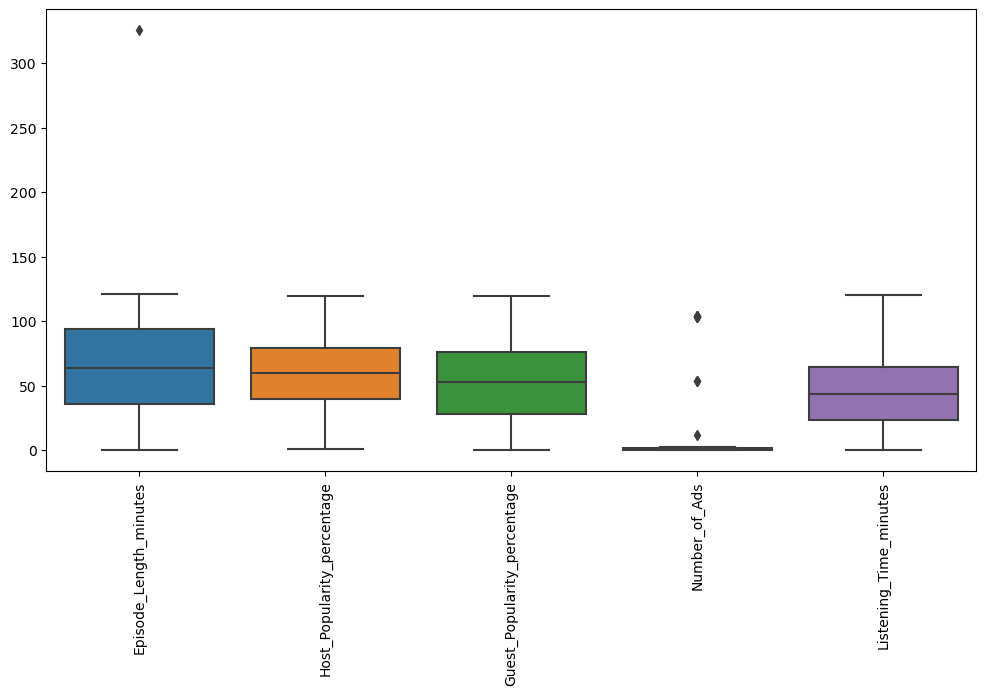

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [15]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,710161.000000,802500.000000,651212.000000,802499.000000,797105.000000
mean,64.394865,59.879792,52.078083,1.358610,45.444668
std,32.983341,22.891991,28.488536,1.149546,27.140915
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.460000,28.070000,0.000000,23.184220
50%,63.740000,60.060000,53.320000,1.000000,43.392270
75%,93.980000,79.560000,76.480000,2.000000,64.814620
max,325.240000,119.460000,119.910000,103.910000,119.970000


In [16]:
# Check what kind of Episodes are they?
train_long_episodes = train[train['Episode_Length_minutes'] >= 150]
train_long_episodes.head()
# Lets delete it... not sure about it.

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
101637,Home & Living,Episode 16,325.24,Lifestyle,50.69,Tuesday,Afternoon,15.01,0.0,Positive,64.31981


In [17]:
# Lets have a look..
train_long_episodes = train[train['Number_of_Ads'] >= 10]
train_long_episodes.head()
# Lets delete it... not sure about it.

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
211159,Wellness Wave,Episode 83,64.83,Health,48.46,Sunday,Evening,NaN,53.37,Positive,50.44892
283606,Health Hour,Episode 15,109.93,Health,67.81,Sunday,Morning,77.90,103.91,Neutral,103.89696
436577,Sports Central,Episode 64,115.25,Sports,28.58,Saturday,Afternoon,23.65,103.00,Neutral,103.12686
495919,Comedy Corner,Episode 79,64.83,Comedy,48.37,Saturday,Evening,NaN,53.42,Neutral,50.44892
537705,Sound Waves,Episode 64,112.27,Music,28.95,Saturday,Morning,10.15,103.75,Neutral,103.12686


In [18]:
train = train[train['Episode_Length_minutes'] <= 150]
train = train[train['Number_of_Ads'] <= 10]

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710150 entries, 1 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 710150 non-null  category
 1   Episode_Title                710150 non-null  object  
 2   Episode_Length_minutes       710150 non-null  float64 
 3   Genre                        710150 non-null  category
 4   Host_Popularity_percentage   710150 non-null  float64 
 5   Publication_Day              710150 non-null  category
 6   Publication_Time             710150 non-null  category
 7   Guest_Popularity_percentage  581561 non-null  float64 
 8   Number_of_Ads                710150 non-null  float64 
 9   Episode_Sentiment            710150 non-null  category
 10  Listening_Time_minutes       705306 non-null  float64 
dtypes: category(5), float64(5), object(1)
memory usage: 41.3+ MB


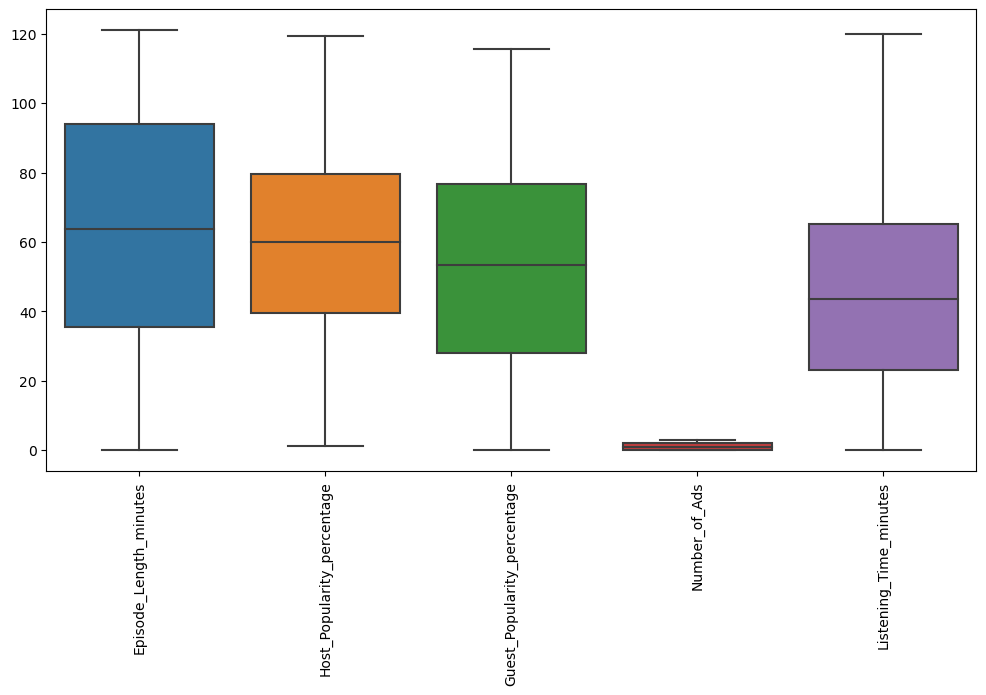

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [21]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,710150.000000,710150.000000,581561.000000,710150.000000,705306.000000
mean,64.394198,59.894245,52.072042,1.360549,45.728920
std,32.981779,22.888900,28.546671,1.111775,27.261742
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.500000,27.960000,0.000000,23.260250
50%,63.740000,60.090000,53.370000,1.000000,43.730000
75%,93.980000,79.570000,76.570000,2.000000,65.185500
max,120.930000,119.460000,115.620000,3.000000,119.970000


### Check Redundant Data

In [22]:
print(train.duplicated().sum())
print(train.duplicated(subset=['Podcast_Name', 'Episode_Title']).sum())
# Be careful, playground datasets are artifically created, so It is possible we have variatnion in the data.
# Conclusion: Only delete the 1:1 duplicates.
train = train.drop_duplicates()


2279
705350


In [23]:
print(train.duplicated().sum())

0


### Show general stats

In [24]:
def show_general_stats(df):
    display(Markdown('### General Stats'))
    display(df.describe())
    display(Markdown('### Data Types'))
    display(df.dtypes)
    display(Markdown('### Missing Values'))
    display(df.isnull().sum())
    display(Markdown('### Shape'))
    display(df.shape)
    display(Markdown('### Head'))
    display(df.head(100))
    display(Markdown('### Tail'))
    display(df.tail(100))
    display(Markdown('### Sample'))
    display(df.sample(100))
    display(Markdown('### '))

In [25]:
show_general_stats(train)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,707871.000000,707871.000000,579522.000000,707871.000000,703270.000000
mean,64.399262,59.892578,52.082746,1.360169,45.727890
std,32.980779,22.887224,28.543809,1.111735,27.259659
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.500000,27.980000,0.000000,23.260251
50%,63.760000,60.090000,53.370000,1.000000,43.731430
75%,93.990000,79.570000,76.590000,2.000000,65.184160
max,120.930000,119.460000,115.620000,3.000000,119.970000


### Data Types

Podcast_Name                   category
Episode_Title                    object
Episode_Length_minutes          float64
Genre                          category
Host_Popularity_percentage      float64
Publication_Day                category
Publication_Time               category
Guest_Popularity_percentage     float64
Number_of_Ads                   float64
Episode_Sentiment              category
Listening_Time_minutes          float64
dtype: object

### Missing Values

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes              0
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    128349
Number_of_Ads                       0
Episode_Sentiment                   0
Listening_Time_minutes           4601
dtype: int64

### Shape

(707871, 11)

### Head

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
5,Fitness First,Episode 19,26.54,Health,48.96,Saturday,Afternoon,NaN,3.0,Positive,22.77047
...,...,...,...,...,...,...,...,...,...,...,...
107,Daily Digest,Episode 96,37.31,News,57.78,Friday,Afternoon,5.62,1.0,Neutral,9.77975
108,Tech Trends,Episode 78,85.12,Technology,62.19,Friday,Morning,9.00,2.0,Positive,58.26835
109,Crime Chronicles,Episode 96,80.33,True Crime,64.13,Thursday,Evening,44.07,0.0,Positive,53.21997
110,Life Lessons,Episode 6,21.48,Lifestyle,53.04,Sunday,Night,11.78,0.0,Negative,12.46019


### Tail

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
799889,Mind & Body,Episode 78,11.31,Health,58.31,Saturday,Night,NaN,1.0,Positive,0.629263
799890,Sports Central,Episode 53,48.18,Sports,38.98,Thursday,Afternoon,63.56,2.0,Positive,45.722005
799891,Funny Folks,Episode 2,111.81,Comedy,61.41,Monday,Evening,15.12,2.0,Positive,64.953933
799892,Humor Hub,Episode 90,50.48,Comedy,56.32,Saturday,Afternoon,NaN,2.0,Negative,45.007477
799893,Sport Spot,Episode 9,105.29,Sports,66.37,Sunday,Afternoon,34.13,1.0,Positive,96.141611
...,...,...,...,...,...,...,...,...,...,...,...
799995,Educational Nuggets,Episode 53,41.64,Education,95.89,Wednesday,Morning,28.55,1.0,Neutral,NaN
799996,Brain Boost,Episode 12,89.78,Education,93.08,Saturday,Evening,93.12,3.0,Positive,56.795223
799997,Tech Trends,Episode 18,77.86,Technology,41.04,Saturday,Afternoon,52.33,2.0,Positive,46.797187
799998,Business Insights,Episode 23,84.53,Business,60.80,Saturday,Afternoon,49.10,0.0,Negative,NaN


### Sample

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
315266,Sound Waves,Episode 60,102.59,Music,39.83,Thursday,Night,57.25,1.0,Positive,58.354130
600719,Educational Nuggets,Episode 15,113.16,Education,66.11,Tuesday,Afternoon,48.77,1.0,Negative,81.000930
301794,Detective Diaries,Episode 55,45.45,True Crime,29.85,Sunday,Night,73.92,3.0,Positive,34.954470
578271,Gadget Geek,Episode 87,62.99,Technology,22.00,Saturday,Afternoon,85.85,0.0,Neutral,56.504600
471202,Criminal Minds,Episode 62,12.22,True Crime,28.64,Friday,Afternoon,52.64,0.0,Positive,7.202760
...,...,...,...,...,...,...,...,...,...,...,...
763699,Style Guide,Episode 76,100.95,Lifestyle,53.52,Sunday,Morning,5.90,3.0,Negative,45.687645
109856,Learning Lab,Episode 94,80.55,Education,73.61,Wednesday,Morning,16.35,1.0,Positive,60.418860
486419,Game Day,Episode 89,61.19,Sports,71.47,Tuesday,Night,NaN,0.0,Negative,51.347090
641137,Tech Talks,Episode 95,91.71,Technology,26.89,Friday,Evening,NaN,0.0,Positive,89.196750


### 

### Numerical missing data fix

In [26]:
# 1. Guest_Popularity: missing = no guest (0), add flag
train['has_guest'] = (~train['Guest_Popularity_percentage'].isna()).astype(int)
train['Guest_Popularity_percentage'].fillna(0, inplace=True)

# 2. Episode_Length: Median
train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].mean(), inplace=True)

# 3. Listening_Time: only data with data!
train = train[train['Listening_Time_minutes'].notna()]

# 4. Number_of_Ads: 0
train['Number_of_Ads'].fillna(0, inplace=True)

In [27]:
train.isnull().sum()

Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
has_guest                      0
dtype: int64

### Categorical missing data fix
Not needed

## Test Data set

### Convert features if needed

#### Delete numerical Outliers

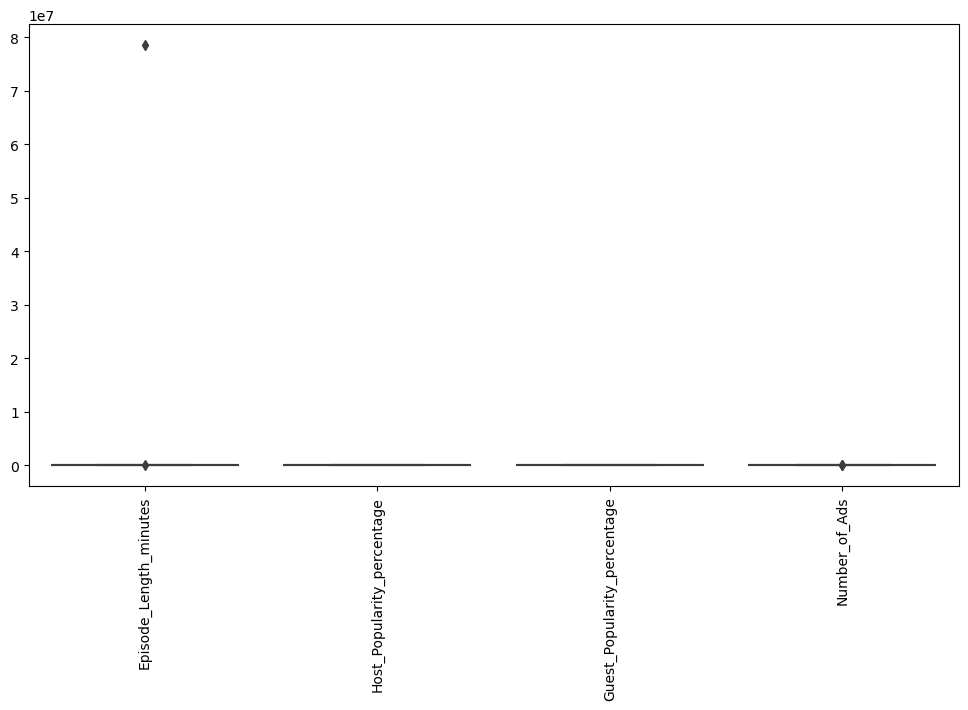

In [30]:
numeric_features = test.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=test[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [31]:
## Delete numerical Outliers

In [32]:
show_general_stats(test)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,2.212640e+05,250000.000000,201168.000000,250000.000000
mean,4.192987e+02,59.716491,52.192796,1.355852
std,1.668545e+05,22.880028,28.445034,4.274399
min,2.470000e+00,2.490000,0.000000,0.000000
25%,3.578000e+01,39.250000,28.320000,0.000000
50%,6.397000e+01,59.900000,53.360000,1.000000
75%,9.415000e+01,79.390000,76.560000,2.000000
max,7.848626e+07,117.760000,116.820000,2063.000000


### Data Types

Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object

### Missing Values

Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

### Shape

(250000, 10)

### Head

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Educational Nuggets,Episode 73,78.960000,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,Sound Waves,Episode 23,27.870000,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,Joke Junction,Episode 11,69.100000,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,Comedy Corner,Episode 73,115.390000,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,Life Lessons,Episode 50,72.320000,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...
95,Business Briefs,Episode 37,45.060000,Business,83.84,Thursday,Morning,NaN,2.0,Negative
96,Daily Digest,Episode 51,8.386211,News,53.28,Thursday,Night,NaN,0.0,Neutral
97,Money Matters,Episode 61,43.500000,Business,24.96,Saturday,Afternoon,NaN,3.0,Negative
98,Business Insights,Episode 49,50.970000,Business,56.31,Saturday,Evening,94.00,1.0,Neutral


### Tail

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
249900,Game Day,Episode 3,92.73,Sports,28.99,Thursday,Morning,67.39,0.0,Positive
249901,Sports Central,Episode 29,52.03,Sports,78.51,Wednesday,Night,5.58,1.0,Positive
249902,Music Matters,Episode 75,NaN,Music,80.86,Tuesday,Morning,NaN,1.0,Neutral
249903,Business Insights,Episode 87,24.91,Business,28.79,Saturday,Evening,1.48,3.0,Negative
249904,Wellness Wave,Episode 43,44.76,Health,29.41,Wednesday,Night,27.76,3.0,Negative
...,...,...,...,...,...,...,...,...,...,...
249995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive


### Sample

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
59941,True Crime Stories,Episode 91,98.36,True Crime,96.99,Monday,Morning,NaN,1.0,Negative
216210,Innovators,Episode 40,105.89,Technology,55.06,Monday,Night,48.09,2.0,Positive
111035,Sport Spot,Episode 13,NaN,Sports,20.71,Saturday,Evening,88.87,1.0,Neutral
135013,Crime Chronicles,Episode 87,86.04,True Crime,55.92,Saturday,Evening,10.16,1.0,Negative
143804,Home & Living,Episode 25,60.07,Lifestyle,89.11,Tuesday,Night,NaN,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...
171160,Gadget Geek,Episode 8,69.53,Technology,91.11,Sunday,Night,29.12,1.0,Positive
147545,Daily Digest,Episode 77,19.05,News,46.27,Saturday,Evening,38.41,1.0,Positive
153812,Gadget Geek,Episode 92,103.20,Technology,65.29,Thursday,Afternoon,86.63,3.0,Neutral
179419,Music Matters,Episode 86,73.92,Music,34.08,Friday,Morning,95.37,2.0,Negative


### 

In [33]:
# 2. Episode_Length: Median
train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].mean(), inplace=True)

In [34]:
# columns_to_convert = ['Study Satisfaction'] # a lot of missing values! over 114k! better we do the this calculation seperated

# df_test = test_preprocessed.copy()

# imputer = IterativeImputer(
#     estimator=RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
#     max_iter=200,
#     random_state=42,
#     min_value=0,
#     imputation_order="ascending" 
# )

# df_subset = df_test[columns_to_convert]
# df_imputed_values = imputer.fit_transform(df_subset)
# df_test[columns_to_convert] = np.round(df_imputed_values).astype(int)

# print(imputer.n_iter_)
# show_general_stats(df_test)

# Scale Numerical features
Not yet, will do a test with xgboost, no scaling is needed

# Scale Categorical Features

In [139]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = train.copy()

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_feature = encoder.fit_transform(df[['Episode_Title']])
df_encoded = pd.DataFrame(encoded_feature, columns=encoder.get_feature_names_out(['Episode_Title']))

df = df.drop(columns=['Episode_Title'])
df = pd.concat([df, df_encoded], axis=1)

# Final DataFrame
train = df.copy()

# Show stats
show_general_stats(train)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,has_guest,Episode_Title_Episode 1,Episode_Title_Episode 10,Episode_Title_Episode 100,Episode_Title_Episode 11,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
count,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,...,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000
mean,64.412581,59.891563,42.624672,1.359373,45.727890,0.818151,0.008058,0.008731,0.008520,0.009085,...,0.009274,0.009289,0.008844,0.008058,0.009049,0.006625,0.009206,0.008859,0.008011,0.012220
std,32.979919,22.885415,32.714370,1.111587,27.259659,0.385720,0.089404,0.093029,0.091911,0.094880,...,0.095853,0.095933,0.093628,0.089404,0.094696,0.081123,0.095503,0.093702,0.089146,0.109867
min,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.670000,39.480000,9.090000,0.000000,23.260251,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.770000,60.090000,42.780000,1.000000,43.731430,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94.010000,79.560000,71.320000,2.000000,65.184160,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,120.930000,119.460000,115.620000,3.000000,119.970000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Types

Podcast_Name                  category
Episode_Length_minutes         float64
Genre                         category
Host_Popularity_percentage     float64
Publication_Day               category
                                ...   
Episode_Title_Episode 95       float64
Episode_Title_Episode 96       float64
Episode_Title_Episode 97       float64
Episode_Title_Episode 98       float64
Episode_Title_Episode 99       float64
Length: 111, dtype: object

### Missing Values

Podcast_Name                  81733
Episode_Length_minutes        81733
Genre                         81733
Host_Popularity_percentage    81733
Publication_Day               81733
                              ...  
Episode_Title_Episode 95      81733
Episode_Title_Episode 96      81733
Episode_Title_Episode 97      81733
Episode_Title_Episode 98      81733
Episode_Title_Episode 99      81733
Length: 111, dtype: int64

### Shape

(785003, 111)

### Head

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Fitness First,26.54,Health,48.96,Saturday,Afternoon,0.00,3.0,Positive,22.77047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Daily Digest,37.31,News,57.78,Friday,Afternoon,5.62,1.0,Neutral,9.77975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,Tech Trends,85.12,Technology,62.19,Friday,Morning,9.00,2.0,Positive,58.26835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Crime Chronicles,80.33,True Crime,64.13,Thursday,Evening,44.07,0.0,Positive,53.21997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,Life Lessons,21.48,Lifestyle,53.04,Sunday,Night,11.78,0.0,Negative,12.46019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tail

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
702364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sample

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
26184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
169561,Sports Central,6.71,Sports,51.43,Sunday,Morning,0.00,2.0,Negative,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81259,Home & Living,92.74,Lifestyle,80.17,Friday,Afternoon,0.00,1.0,Neutral,57.35559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
734572,Daily Digest,97.99,News,60.94,Thursday,Evening,26.95,0.0,Neutral,74.02247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45952,Style Guide,73.80,Lifestyle,33.48,Sunday,Night,0.00,0.0,Positive,40.09597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248278,Healthy Living,32.89,Health,50.47,Sunday,Evening,83.87,2.0,Neutral,21.23225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239902,Life Lessons,45.12,Lifestyle,82.81,Friday,Morning,71.94,0.0,Negative,42.38312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177016,Sports Central,70.36,Sports,38.27,Thursday,Night,74.88,2.0,Neutral,62.15419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473609,Sports Weekly,75.60,Sports,24.92,Thursday,Evening,85.24,0.0,Neutral,45.47404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 

# Save preprocessed dataframe

In [ ]:
if KAGGLE_ENV:
    train.to_csv('/kaggle/working/s5-e4-train_preprocessed.csv', index=False)
else:
    train.to_csv( '../kaggle/working/s5-e4-train_preprocessed.csv', index=False)

In [ ]:
if KAGGLE_ENV:
    test.to_csv('/kaggle/working/s5-e4-test_preprocessed.csv', index=False)
else:
    test.to_csv( '../kaggle/working/s5-e4-test_preprocessed.csv', index=False)

# Feature Selection (optional)
Delete attributes there aren't providing any information (correlation matrix).

# Create new Features (optional)
- Discretizing Continuous Features
- Decomposing Features and Date/Time Variables
- Aggregate attributes to better new attributes